In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import confusion_matrix

## Reading and Visualizing the Data

In [2]:
data = pd.read_csv("data.csv")
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


- **Unnamed Column with NA Values:**
  - Contains missing values (NaN) which do not contribute to the analysis.

- **ID Column:**
  - Does not provide meaningful information for clustering analysis.
  - Including it could distort the clustering results.

## removing any unnecessary columns

In [3]:
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data = data.drop('id', axis=1)
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Preprocessing the Data and scaling

In [4]:

X = data.iloc[:, 1:].values # Feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # scaling the data to have mean=0 and variance=1
data = data.dropna()  # Removes rows with missing values.


## Implementing KMeans Clustering & Elbow method

In [34]:
from kneed import KneeLocator


class KMeans:
    def __init__(self, max_k=10, tol=1e-4, max_iter=100):
        self.max_k = max_k # this represent the maximum considered number of clusters
        self.tol = tol # this represent the tolerance value
        self.max_iter = max_iter # max iterations for KMeans algorithm
        self.centroids = None # centroids of the clusters
        self.labels = None # the labels of the clusters
        self.k = None # the number of clusters, we used elbow to decide it
        self.inertia_value = None  # Inertia value

    def fit(self, X, k=None):
        self.k = k if k else self.elbow_method(X) # if k is not provided, we use elbow method to decide it
        if self.k > X.shape[0]: # if k is greater than the number of data points, which might be senseless but we handle it
            raise ValueError(f"k={self.k} exceeds data points={X.shape[0]}.")
        np.random.seed(42)
        self.centroids = X[np.random.choice(X.shape[0], self.k, replace=False)] # random initialization of centroids
        for _ in range(self.max_iter):  # Iterate up to the maximum number of iterations
            dists = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)  # Calculate the distance between each data point and the centroids
            self.labels = np.argmin(dists, axis=1)  # Assign each data point to the nearest centroid
            new_centroids = np.array([X[self.labels == j].mean(axis=0) for j in range(self.k)])  # Compute the new centroids as the mean of the assigned points

            # Inertia calculation (sum of squared errors)
            self.inertia_value = self.calculate_inertia(X)  # Calculate the inertia to evaluate clustering quality

            if np.all(np.abs(new_centroids - self.centroids) < self.tol):  # Check for convergence by comparing the change in centroids
                break  # If the change is less than the tolerance, stop the iteration
            self.centroids = new_centroids  # Update the centroids with the new values
        return self
    def calculate_inertia(self, X):
        # Calculate the inertia (sum of squared errors)
        dists = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        labels = np.argmin(dists, axis=1)
        inertia = sum(np.sum((X[labels == i] - self.centroids[i]) ** 2) for i in range(self.k))
        return inertia

    def predict(self, X):
        dists = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(dists, axis=1)
    def elbow_method(self, X):
        sse = []  # Initialize a list to store the sum of squared errors (SSE) for each k
        for k in range(1, self.max_k + 1):  # Iterate over the range of cluster numbers from 1 to max_k
            self.fit(X, k)  # Fit the KMeans model with k clusters
            dists = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)  # Calculate the distance between each data point and the centroids
            labels = np.argmin(dists, axis=1)  # Assign each data point to the nearest centroid
            sse.append(sum(np.sum((X[labels == i] - self.centroids[i]) ** 2) for i in range(k)))  # Calculate and append the SSE for the current k

        p1, p2 = np.array([1, sse[0]]), np.array([self.max_k, sse[-1]])  # Define two points for the line: (1, first SSE) and (max_k, last SSE)
        dists = [np.abs(np.cross(p2 - p1, np.array([k, sse[k - 1]]) - p1)) / np.linalg.norm(p2 - p1) for k in range(1, self.max_k + 1)]  # Calculate the perpendicular distances from each point to the line
        opt_k = np.argmax(dists) + 1  # Find the index of the maximum distance, which corresponds to the optimal k
        print(f"Optimal k (Manual): {opt_k}")  # Print the optimal number of clusters
        self.k = opt_k  # Set the optimal number of clusters

        plt.plot(range(1, self.max_k + 1), sse, marker='o')  # Plot the SSE values against the number of clusters

        plt.title("Elbow Method")  # Set the title of the plot
        plt.axvline(x=opt_k, color='r', linestyle='--', label=f'Optimal k={opt_k}')  # Draw a vertical line at the optimal k
        plt.xlabel("Clusters (k)")  # Label the x-axis
        plt.ylabel("SSE")  # Label the y-axis
        plt.show()  # Display the plot
        return opt_k  # Return the optimal number of clusters

    def kneedle_elbow_method(self, X):
        sse = []
        for k in range(1, self.max_k + 1):
            self.fit(X, k)
            dists = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(dists, axis=1)
            sse.append(sum(np.sum((X[labels == i] - self.centroids[i]) ** 2) for i in range(k)))

        kneedle = KneeLocator(range(1, self.max_k + 1), sse, curve='convex', direction='decreasing')
        opt_k = kneedle.elbow

        plt.plot(range(1, self.max_k + 1), sse, marker='o')
        plt.axvline(x=opt_k, color='r', linestyle='--', label=f'Optimal k={opt_k}')
        plt.title("Kneedle Elbow Method")
        plt.xlabel("Clusters (k)")
        plt.ylabel("SSE")
        plt.legend()
        plt.show()

        print(f"Optimal k (Kneedle): {opt_k}")
        self.k = opt_k
        return opt_k

Optimal k (Manual): 3


/tmp/ipykernel_10553/953931944.py:51: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dists = [np.abs(np.cross(p2 - p1, np.array([k, sse[k - 1]]) - p1)) / np.linalg.norm(p2 - p1) for k in range(1, self.max_k + 1)]  # Calculate the perpendicular distances from each point to the line


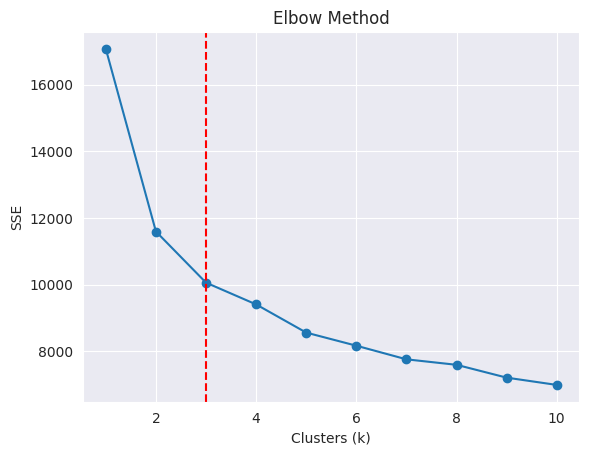

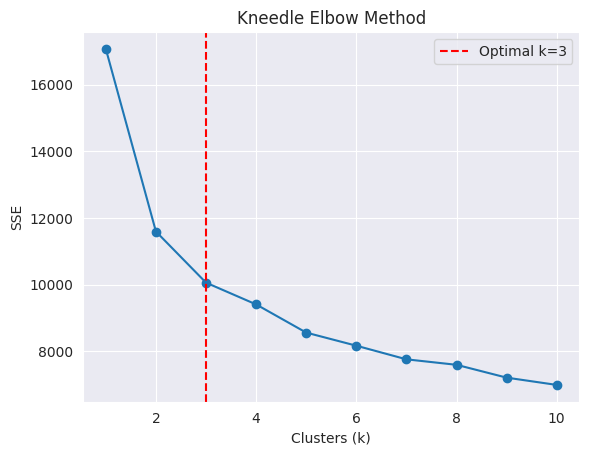

Optimal k (Kneedle): 3


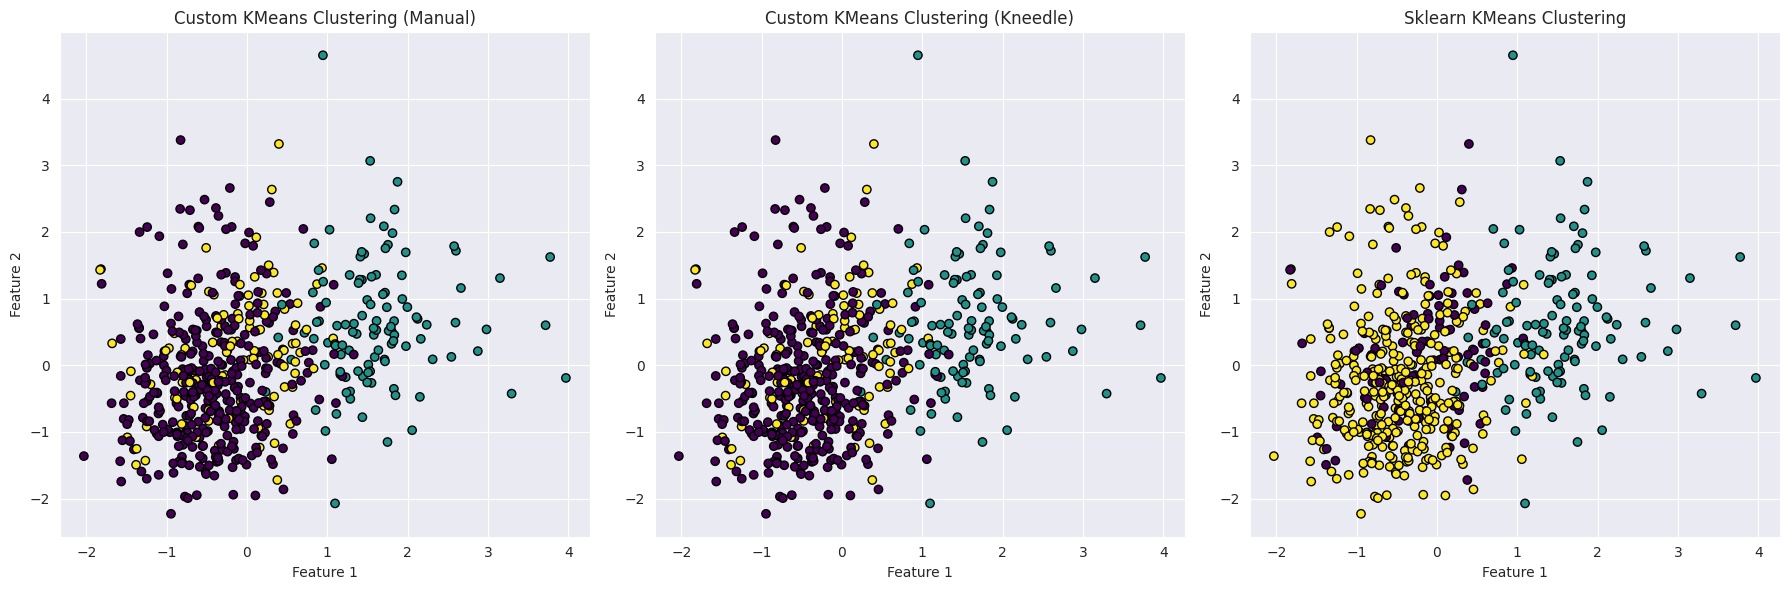

Custom KMeans Silhouette Score (Manual): 0.3143840098608098
Custom KMeans Silhouette Score (Kneedle): 0.3143840098608098
Sklearn KMeans Silhouette Score: 0.3151862330494096


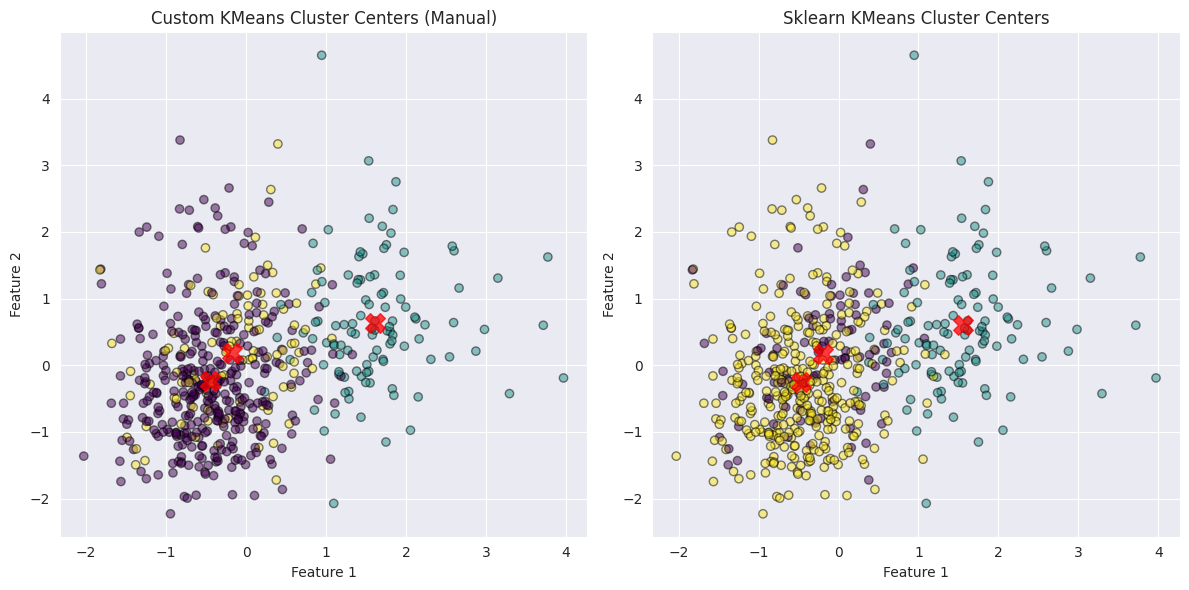

In [47]:
from sklearn.cluster import KMeans as SklearnKMeans
from sklearn.metrics import silhouette_score

# Assuming X_scaled is already defined and scaled

kmeans = KMeans(max_k=10)
optimal_k_manual = kmeans.elbow_method(X_scaled)
kmeans.fit(X_scaled, optimal_k_manual)
labels_custom_manual = kmeans.labels


optimal_k_kneedle = kmeans.kneedle_elbow_method(X_scaled)
kmeans.fit(X_scaled, optimal_k_kneedle)
labels_custom_kneedle = kmeans.labels

# Sklearn KMeans for comparison
sklearn_kmeans = SklearnKMeans(n_clusters=optimal_k_manual,init='k-means++', max_iter=300, tol=1e-4, random_state=42)
sklearn_kmeans.fit(X_scaled)
labels_sklearn = sklearn_kmeans.labels_
centroids_sklearn = sklearn_kmeans.cluster_centers_
inertia_sklearn = sklearn_kmeans.inertia_
# Visualizing the clusters results
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_custom_manual, cmap='viridis', edgecolor='k')
plt.title("Custom KMeans Clustering (Manual)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 3, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_custom_kneedle, cmap='viridis', edgecolor='k')
plt.title("Custom KMeans Clustering (Kneedle)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 3, 3)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_sklearn, cmap='viridis', edgecolor='k')
plt.title("Sklearn KMeans Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()

# Silhouette Score which is a metric to evaluate the model
sil_score_custom_manual = silhouette_score(X_scaled, labels_custom_manual)
sil_score_custom_kneedle = silhouette_score(X_scaled, labels_custom_kneedle)
sil_score_sklearn = silhouette_score(X_scaled, labels_sklearn)

print(f"Custom KMeans Silhouette Score (Manual): {sil_score_custom_manual}")
print(f"Custom KMeans Silhouette Score (Kneedle): {sil_score_custom_kneedle}")
print(f"Sklearn KMeans Silhouette Score: {sil_score_sklearn}")

# Visualize the cluster centers
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_custom_manual, cmap='viridis', edgecolor='k', alpha=0.5)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title("Custom KMeans Cluster Centers (Manual)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 2, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_sklearn, cmap='viridis', edgecolor='k', alpha=0.5)
plt.scatter(sklearn_kmeans.cluster_centers_[:, 0], sklearn_kmeans.cluster_centers_[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title("Sklearn KMeans Cluster Centers")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()

- **Optimal Number of Clusters (k):**
  - The elbow method was used to determine the optimal number of clusters.
  - The plot of clusters (k) vs. SSE showed:
    - 1 cluster: SSE > 16000
    - 2 clusters: SSE ≈ 12000
    - 3 clusters: SSE ≈ 10000
  - The optimal k was chosen to be 3 based on the elbow point.

- **Clustering Implementation:**
  - Both a custom KMeans implementation using NumPy and the built-in KMeans from scikit-learn were used.
  - Both implementations identified 3 cluster centers.

- **Silhouette Scores:**
  - Custom KMeans Silhouette Score: 0.3143840098608098
  - Sklearn KMeans Silhouette Score: 0.3151862330494096
  - The silhouette scores for both implementations were very close, indicating similar clustering quality.

- **Cluster Visualization:**
  - The clusters formed by both the custom and sklearn KMeans implementations looked almost identical.
  - The cluster centers for both implementations were nearly the same.

### Custom KMeans comparison with SKlearn and evaluating the Silhouette Score and elbow method

Optimal k (Manual): 5


/tmp/ipykernel_10553/953931944.py:51: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dists = [np.abs(np.cross(p2 - p1, np.array([k, sse[k - 1]]) - p1)) / np.linalg.norm(p2 - p1) for k in range(1, self.max_k + 1)]  # Calculate the perpendicular distances from each point to the line


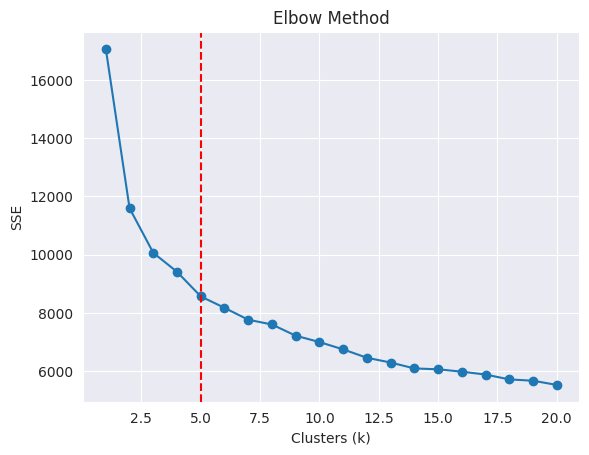

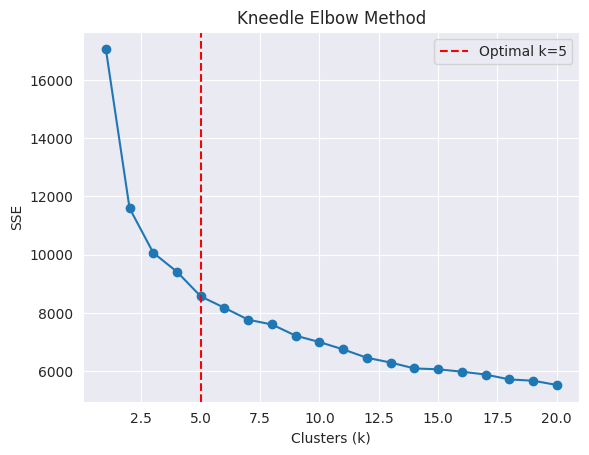

Optimal k (Kneedle): 5


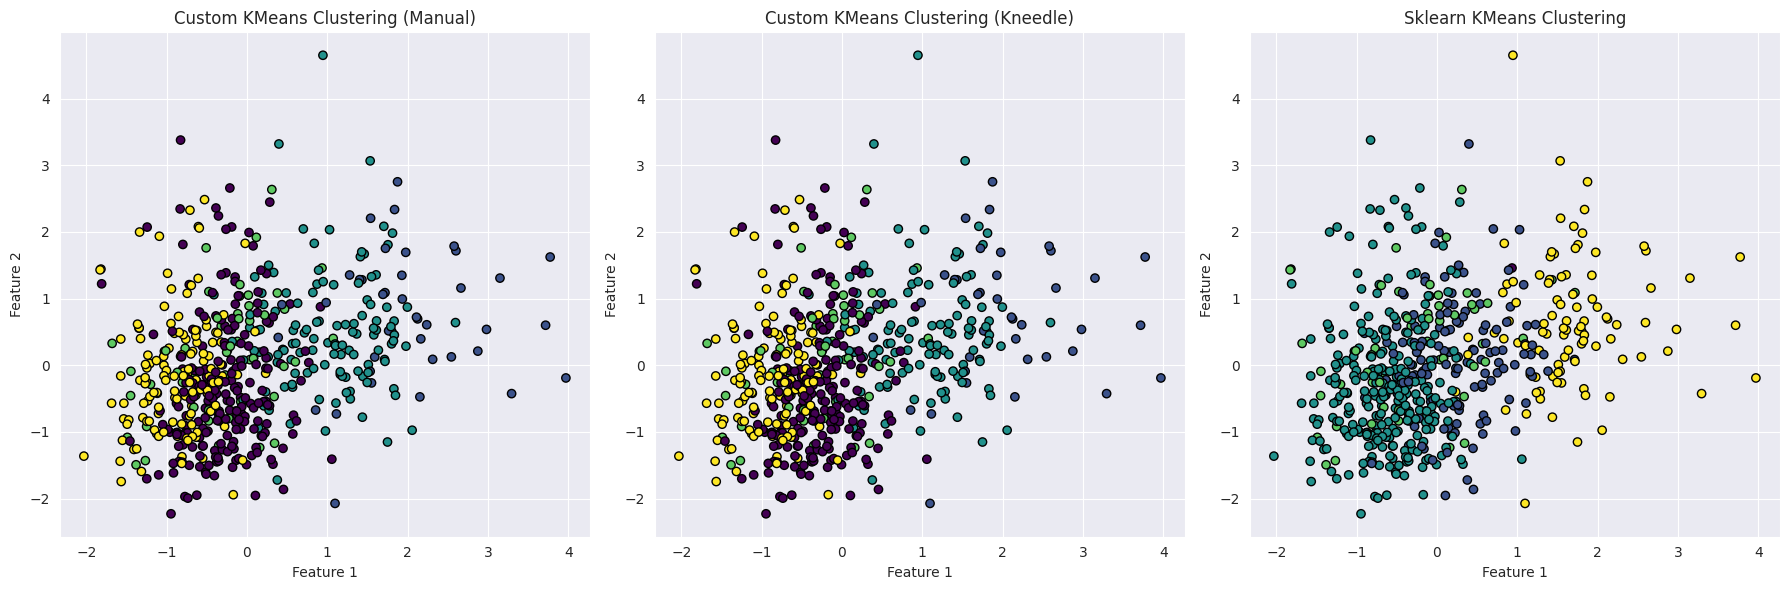

Custom KMeans Silhouette Score (Manual): 0.16754047393132004
Custom KMeans Silhouette Score (Kneedle): 0.16754047393132004
Sklearn KMeans Silhouette Score: 0.16454819399495382


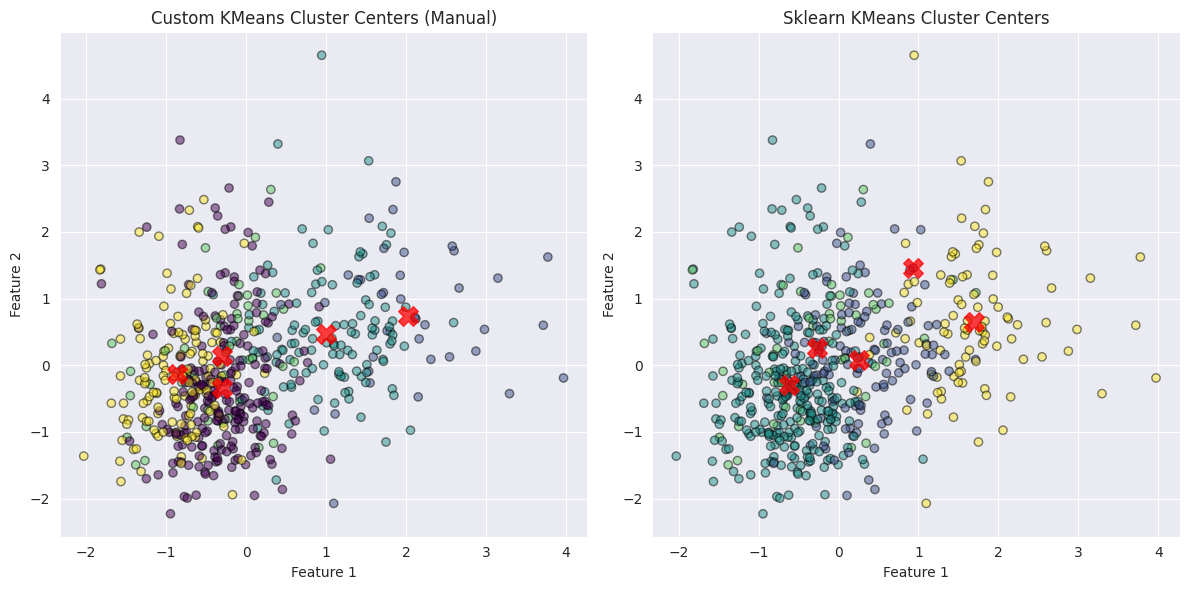

In [35]:
from sklearn.cluster import KMeans as SklearnKMeans
from sklearn.metrics import silhouette_score


kmeans = KMeans(max_k=20)
optimal_k_manual = kmeans.elbow_method(X_scaled)
kmeans.fit(X_scaled, optimal_k_manual)
labels_custom_manual = kmeans.labels

optimal_k_kneedle = kmeans.kneedle_elbow_method(X_scaled)
kmeans.fit(X_scaled, optimal_k_kneedle)
labels_custom_kneedle = kmeans.labels

# Sklearn KMeans for comparison
sklearn_kmeans = SklearnKMeans(n_clusters=optimal_k_manual,init='k-means++', max_iter=300, tol=1e-4, random_state=42)
sklearn_kmeans.fit(X_scaled)
labels_sklearn = sklearn_kmeans.labels_
centroids_sklearn = sklearn_kmeans.cluster_centers_
inertia_sklearn = sklearn_kmeans.inertia_
# Visualizing the clusters results
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_custom_manual, cmap='viridis', edgecolor='k')
plt.title("Custom KMeans Clustering (Manual)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 3, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_custom_kneedle, cmap='viridis', edgecolor='k')
plt.title("Custom KMeans Clustering (Kneedle)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 3, 3)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_sklearn, cmap='viridis', edgecolor='k')
plt.title("Sklearn KMeans Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()

# Silhouette Score which is a metric to evaluate the model
sil_score_custom_manual = silhouette_score(X_scaled, labels_custom_manual)
sil_score_custom_kneedle = silhouette_score(X_scaled, labels_custom_kneedle)
sil_score_sklearn = silhouette_score(X_scaled, labels_sklearn)

print(f"Custom KMeans Silhouette Score (Manual): {sil_score_custom_manual}")
print(f"Custom KMeans Silhouette Score (Kneedle): {sil_score_custom_kneedle}")
print(f"Sklearn KMeans Silhouette Score: {sil_score_sklearn}")

# Visualize the cluster centers
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_custom_manual, cmap='viridis', edgecolor='k', alpha=0.5)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title("Custom KMeans Cluster Centers (Manual)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 2, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_sklearn, cmap='viridis', edgecolor='k', alpha=0.5)
plt.scatter(sklearn_kmeans.cluster_centers_[:, 0], sklearn_kmeans.cluster_centers_[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title("Sklearn KMeans Cluster Centers")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()

- **Optimal Number of Clusters (k):**
  - The elbow method determined the optimal number of clusters.
  - The plot of clusters (k) vs. SSE showed:
    - 1 cluster: SSE > 16000
    - 2 clusters: SSE ≈ 12000
    - 3 clusters: SSE ≈ 10000
  - Optimal k chosen: 5 (both manual and Kneedle methods).

- **Clustering Implementation:**
  - Custom KMeans (NumPy) and sklearn KMeans used.
  - Both identified 5 cluster centers.

- **Silhouette Scores:**
  - [ s = \frac{b - a}{\max(a, b)} ] Where (a) is the mean intra-cluster distance and (b) is the mean nearest-cluster distance.
  - Custom KMeans (Manual): 0.16754047393132004
  - Custom KMeans (Kneedle): 0.16754047393132004
  - Sklearn KMeans: 0.16454819399495382
  - Scores indicate similar clustering quality.

- **Cluster Visualization:**
  - Clusters from both implementations looked almost identical.
  - Cluster centers were nearly the same.

- **Differences Between Implementations:**
  - **Initialization of Centroids:**
    - Custom: `np.random.choice` with fixed seed.
    - Sklearn: 'k-means++' initialization.
  - **Convergence Criteria:**
    - Custom: Absolute difference between old and new centroids.
    - Sklearn: More sophisticated convergence check.
  - **Inertia Calculation:**
    - Custom: Manual calculation.
    - Sklearn: Optimized internal methods.
  - **Iteration Limit:**
    - Custom: Fixed number of iterations (`self.max_iter`).
    - Sklearn: Similar but may have different defaults.
  - **Tolerance:**
    - Custom: `self.tol` for convergence.
    - Sklearn: Default tolerance value.

## Applying Regular PCA

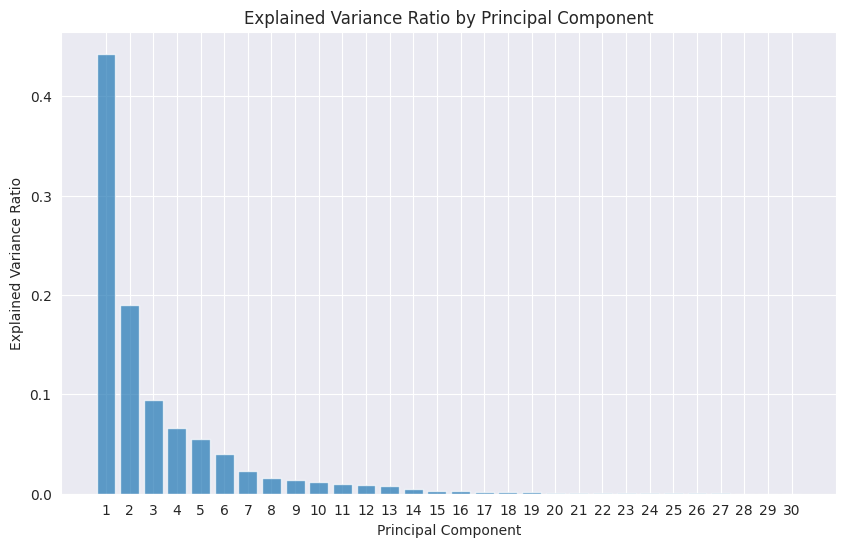

In [36]:
pca = PCA()
features_pca = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center')
plt.title('Explained Variance Ratio by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()

## Plotting Cumulative Explained Variance

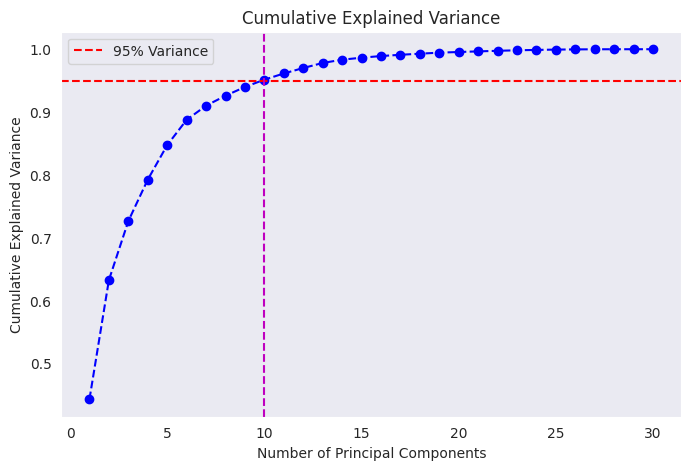

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axvline(x=10, color ='m',linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid()
plt.show()

### Note:
The Y = 0.95 line which represents the Variance = 0.95 has intersected the Cumulative Variance at 10 Principle Components

# Find the smallest number of components needed to retain at least 95% of the variance

In [9]:
optimal_components = next(i for i, total in enumerate(cumulative_variance, 1) if total >= 0.95)
print(f"Optimal number of components to retain 95% variance: {optimal_components}")

Optimal number of components to retain 95% variance: 10


## Plotting Scatter Plot of First Two Principle Components

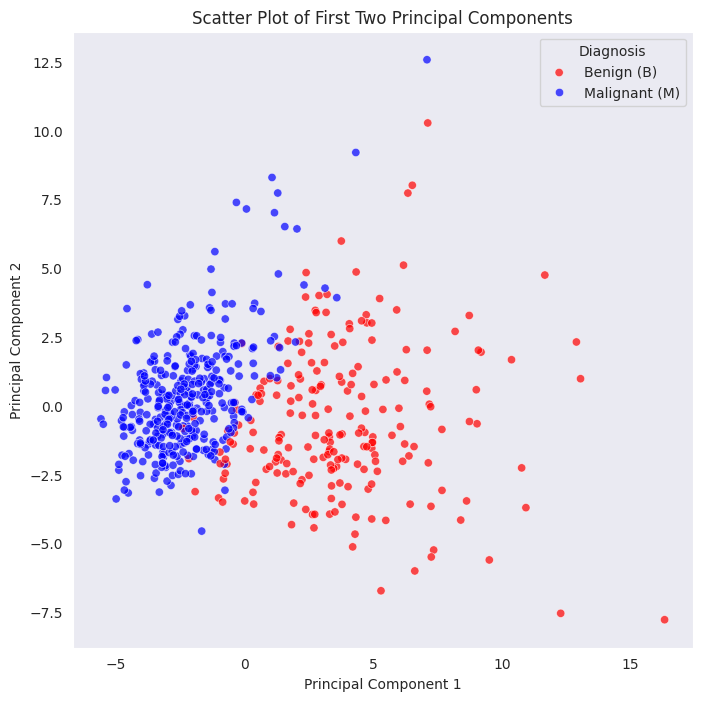

In [10]:
label_encoder = LabelEncoder()
data['diagnosis'] = label_encoder.fit_transform(data['diagnosis']) 
pca_optimal = PCA(n_components=optimal_components)
features_pca_optimal = pca_optimal.fit_transform(X_scaled)
pca_df = pd.DataFrame(features_pca_optimal, columns=[f'PC{i+1}' for i in range(optimal_components)])
labels = data['diagnosis']
pca_df['diagnosis'] = labels  # Add labels back for visualization if needed
plt.figure(figsize=(8, 8))
sns.scatterplot(x='PC1', y='PC2', hue=labels, data=pca_df, alpha=0.7, palette={0: 'blue', 1: 'red'})
plt.title('Scatter Plot of First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Diagnosis', labels=['Benign (B)', 'Malignant (M)'])
plt.grid()
plt.show()

## After we applied the PCA using its Sklearn, Now we will apply the manually implemented One 

In [39]:
class PCAAnalyzer:
    def __init__(self, data, target_column):
        self.data = data
        self.target_column = target_column
        self.features_normalized = None
        self.eigenvalues = None
        self.eigenvectors = None
        self.explained_variance_ratio = None
        self.cumulative_variance = None

    def preprocess(self):
        features = self.data.drop(columns=[self.target_column], errors='ignore')
        self.features_normalized = (features - features.mean()) / features.std()

    def compute_pca(self):
        # Compute the PCA by calculating eigenvalues and eigenvectors of the covariance matrix.
        cov_matrix = np.cov(self.features_normalized.T)
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        # Sort eigenvalues and eigenvectors in descending order of eigenvalues
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[sorted_indices]
        self.eigenvectors = eigenvectors[:, sorted_indices]
        
        # Calculate explained variance ratio
        self.explained_variance_ratio = self.eigenvalues / self.eigenvalues.sum()
        self.cumulative_variance = np.cumsum(self.explained_variance_ratio)

    def get_results(self):
        # Return the PCA results including eigenvalues, explained variance ratio, and cumulative variance.
        return {
            'eigenvalues': self.eigenvalues,
            'eigenvectors': self.eigenvectors,
            'explained_variance_ratio': self.explained_variance_ratio,
            'cumulative_variance': self.cumulative_variance,
            'features_normalized': self.features_normalized
        }

def perform_pca(data, target_column):
   # Perform PCA on the given dataset.

    pca_analyzer = PCAAnalyzer(data, target_column)
    pca_analyzer.preprocess()
    pca_analyzer.compute_pca()
    return pca_analyzer.get_results()

results = perform_pca(data, target_column='diagnosis')

# Print results
eigenvvalues = results['eigenvalues']
eigenvectors = results['eigenvectors']
explained_variance_ratio = results['explained_variance_ratio']
cumulative_variance =  results['cumulative_variance']
features_normalized = results['features_normalized']


## Plotting Cumulative Explained Variance

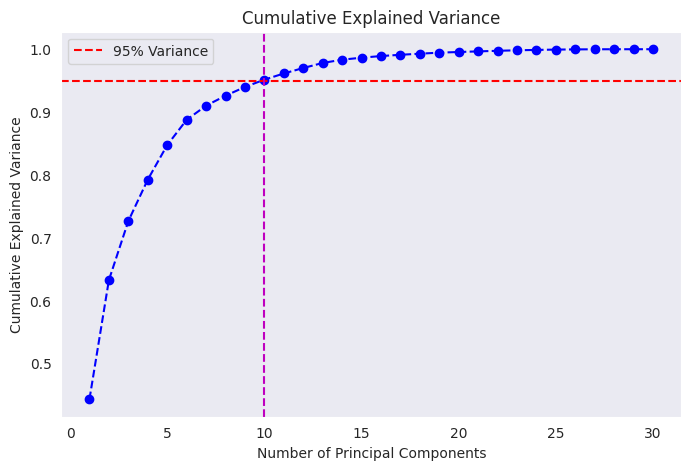

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axvline(x=10, color ='m',linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid()
plt.show()




In [13]:
# Find the smallest number of components needed to retain at least 95% of the variance
optimal_components = next(i for i, total in enumerate(cumulative_variance, 1) if total >= 0.95)
print(f"Optimal number of components to retain 95% variance: {optimal_components}")

Optimal number of components to retain 95% variance: 10


## Plotting Custom Scatter Plot of First Two Principle Components

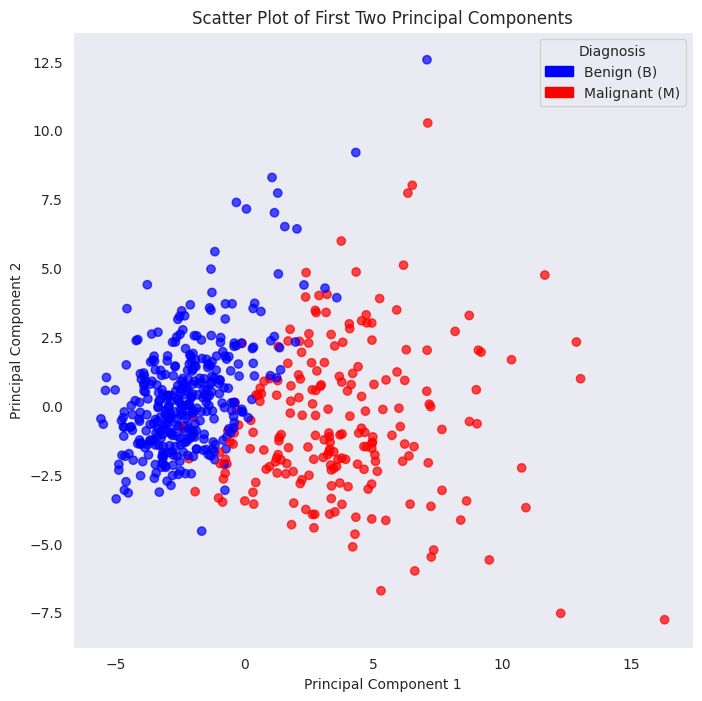

In [14]:
top_eigenvectors = eigenvectors[:, :optimal_components]
#top_eigenvectors = eigenvectors[:optimal_components]
features_pca_optimal = np.dot(features_normalized, top_eigenvectors)
pca_df = pd.DataFrame(features_pca_optimal, columns=[f'PC{i+1}' for i in range(optimal_components)])
pca_df['diagnosis'] = labels
plt.figure(figsize=(8, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['diagnosis'], cmap='bwr', alpha=0.7)
plt.title('Scatter Plot of First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend_labels = [
    mpatches.Patch(color='blue', label='Benign (B)'),
    mpatches.Patch(color='red', label='Malignant (M)')
]
plt.legend(handles=legend_labels, title='Diagnosis')
plt.grid()
plt.show()

# Key Insights and Notes:
 **1. Preprocessing**:
  - Missing values were filled with column means, and features were normalized for consistent scaling.
  - The 'diagnosis' column was encoded as binary (M -> 1, B -> 0).

 **2. PCA Process**:
  - PCA identified principal components by analyzing the covariance matrix via eigen decomposition.
  - Only the top components were retained to explain 95% of the variance, reducing dimensionality.

 **3. Results**:
  - Cumulative explained variance helped determine the optimal number of components.
  - The reduced dataset retains most of the variance and is more efficient for further analysis.

 **4. Visualization**:
  - The scatter plot of the first two principal components shows a clear separation of classes (Malignant vs. Benign).

 **5. Considerations**:
  - PCA simplifies data but reduces interpretability of individual features.
  - It assumes linear relationships and may not capture complex patterns.

 **6. Comparing Custom Model and Normal Model**:
  - Using eigenvalues for the implementation produced results almost identical to the standard PCA implementation.


## Experiment 1: Applying K-means without PCA

Optimal k (Manual): 3


/tmp/ipykernel_10553/953931944.py:51: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dists = [np.abs(np.cross(p2 - p1, np.array([k, sse[k - 1]]) - p1)) / np.linalg.norm(p2 - p1) for k in range(1, self.max_k + 1)]  # Calculate the perpendicular distances from each point to the line


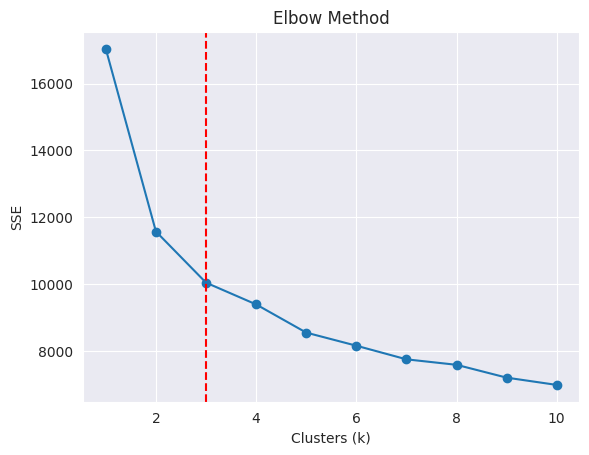

In [48]:
pca_results = perform_pca(data, target_column='diagnosis')
features_normalized = pca_results['features_normalized'].to_numpy()
eigenvectors = pca_results['eigenvectors']
labels_custom_manual = kmeans.labels
kmeans_no_pca = KMeans()
# optimal_k_manual =kmeans_no_pca.elbow_method(features_normalized)
kmeans_no_pca.fit(features_normalized)
labels_no_pca = kmeans.labels
silhouette_no_pca = silhouette_score(features_normalized, labels_custom_manual)
sse_kmeans_no_pca = kmeans_no_pca.inertia_value

## Experiment 2: Applying PCA then Cluster Using K-means (multiple number of principal component)

Optimal k (Manual): 3


/tmp/ipykernel_10553/953931944.py:51: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dists = [np.abs(np.cross(p2 - p1, np.array([k, sse[k - 1]]) - p1)) / np.linalg.norm(p2 - p1) for k in range(1, self.max_k + 1)]  # Calculate the perpendicular distances from each point to the line


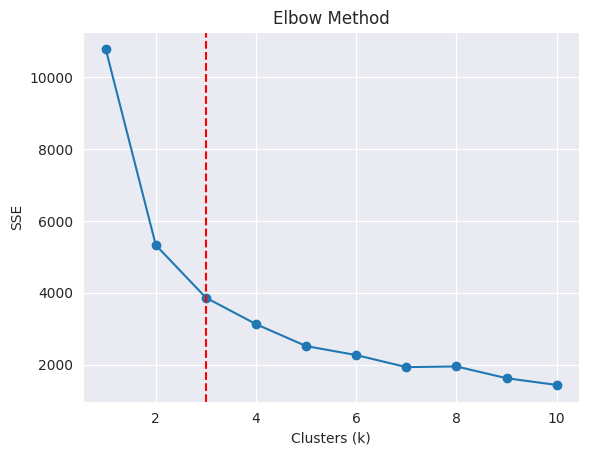

Optimal k (Manual): 3


/tmp/ipykernel_10553/953931944.py:51: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dists = [np.abs(np.cross(p2 - p1, np.array([k, sse[k - 1]]) - p1)) / np.linalg.norm(p2 - p1) for k in range(1, self.max_k + 1)]  # Calculate the perpendicular distances from each point to the line


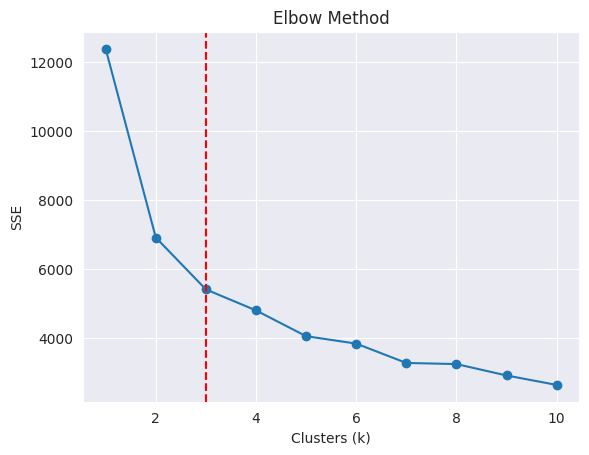

Optimal k (Manual): 3


/tmp/ipykernel_10553/953931944.py:51: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dists = [np.abs(np.cross(p2 - p1, np.array([k, sse[k - 1]]) - p1)) / np.linalg.norm(p2 - p1) for k in range(1, self.max_k + 1)]  # Calculate the perpendicular distances from each point to the line


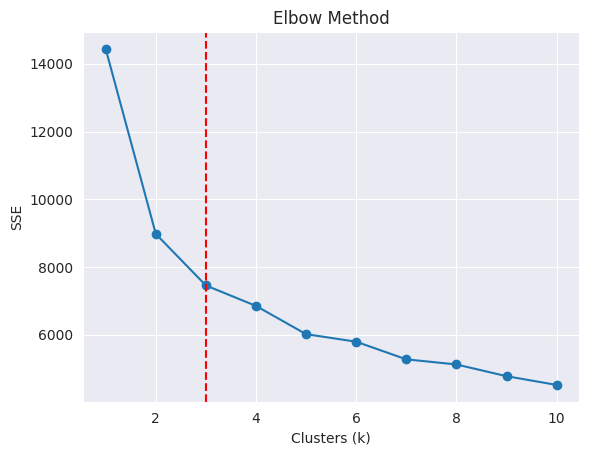

In [49]:


# Reduce dimensions using the top principal components
X_pca_2d = np.dot(features_normalized, eigenvectors[:, :2])  # Top 2 components
X_pca_3d = np.dot(features_normalized, eigenvectors[:, :3])  # Top 3 components
X_pca_5d = np.dot(features_normalized, eigenvectors[:, :5])  # Top 5 components

# KMeans clustering after PCA reduction to 2 components
kmeans_with_pca_2d = KMeans()
kmeans_with_pca_2d.fit(X_pca_2d)
labels_with_pca_2d = kmeans_with_pca_2d.labels
silhouette_with_pca_2d = silhouette_score(X_pca_2d, labels_with_pca_2d)
sse_kmeans_with_pca_2d = kmeans_with_pca_2d.inertia_value

# KMeans clustering after PCA reduction to 3 components
kmeans_with_pca_3d = KMeans()
kmeans_with_pca_3d.fit(X_pca_3d)
labels_with_pca_3d = kmeans_with_pca_3d.labels
silhouette_with_pca_3d = silhouette_score(X_pca_3d, labels_with_pca_3d)
sse_kmeans_with_pca_3d = kmeans_with_pca_3d.inertia_value

# KMeans clustering after PCA reduction to 5 components
kmeans_with_pca_5d = KMeans()
kmeans_with_pca_5d.fit(X_pca_5d)
labels_with_pca_5d = kmeans_with_pca_5d.labels
silhouette_with_pca_5d = silhouette_score(X_pca_5d, labels_with_pca_5d)
sse_kmeans_with_pca_5d = kmeans_with_pca_5d.inertia_value

## Printing SSEs and Silhouette Scores

In [50]:
# Results
print(f"Sum of Squared Errors for KMeans (without PCA): {sse_kmeans_no_pca}")
print(f"Sum of Squared Errors for KMeans (with PCA 2D): {sse_kmeans_with_pca_2d}")
print(f"Sum of Squared Errors for KMeans (with PCA 3D): {sse_kmeans_with_pca_3d}")
print(f"Sum of Squared Errors for KMeans (with PCA 5D): {sse_kmeans_with_pca_5d}")

# Silhouette Scores
print(f"Silhouette Score without PCA: {silhouette_no_pca}")
print(f"Silhouette Score with PCA (2D): {silhouette_with_pca_2d}")
print(f"Silhouette Score with PCA (3D): {silhouette_with_pca_3d}")
print(f"Silhouette Score with PCA (5D): {silhouette_with_pca_5d}")

Sum of Squared Errors for KMeans (without PCA): 10044.114518035887
Sum of Squared Errors for KMeans (with PCA 2D): 3864.3446322901145
Sum of Squared Errors for KMeans (with PCA 3D): 5414.04630161809
Sum of Squared Errors for KMeans (with PCA 5D): 7453.684447529086
Silhouette Score without PCA: 0.31438400986080983
Silhouette Score with PCA (2D): 0.4910071765416258
Silhouette Score with PCA (3D): 0.42879362596318327
Silhouette Score with PCA (5D): 0.36048386145415884


## Visulaization of Clustering in Both Experiments

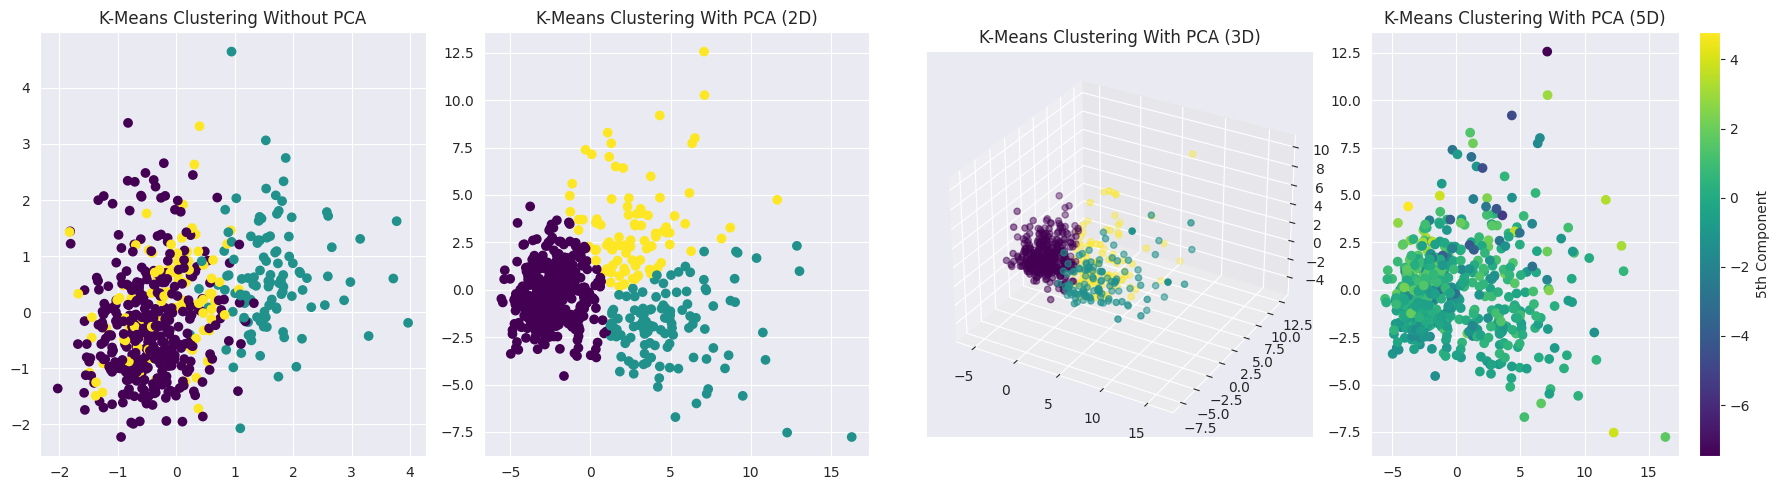

In [51]:
# Visualizations
fig = plt.figure(figsize=(18, 5))

# 2D Visualization (without PCA)
ax1 = fig.add_subplot(1, 4, 1)
ax1.scatter(features_normalized[:, 0], features_normalized[:, 1], c=labels_no_pca, cmap='viridis')
ax1.set_title("K-Means Clustering Without PCA")

# 2D Visualization (with PCA - 2 components)
ax2 = fig.add_subplot(1, 4, 2)
ax2.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels_with_pca_2d, cmap='viridis')
ax2.set_title("K-Means Clustering With PCA (2D)")

# 3D Visualization (with PCA - 3 components)
ax3 = fig.add_subplot(1, 4, 3, projection='3d')
ax3.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=labels_with_pca_3d, cmap='viridis')
ax3.set_title("K-Means Clustering With PCA (3D)")


# 5D Visualization (using color to represent the 4th and 5th dimensions)
ax4 = fig.add_subplot(1, 4, 4)
sc = ax4.scatter(X_pca_5d[:, 0], X_pca_5d[:, 1], c=X_pca_5d[:, 4], cmap='viridis')  # Using the 5th component for color
fig.colorbar(sc, ax=ax4, label="5th Component")
ax4.set_title("K-Means Clustering With PCA (5D)")


plt.tight_layout()
plt.show()

## Visulaization of Clustering in 2nd Experiment with Original Labels

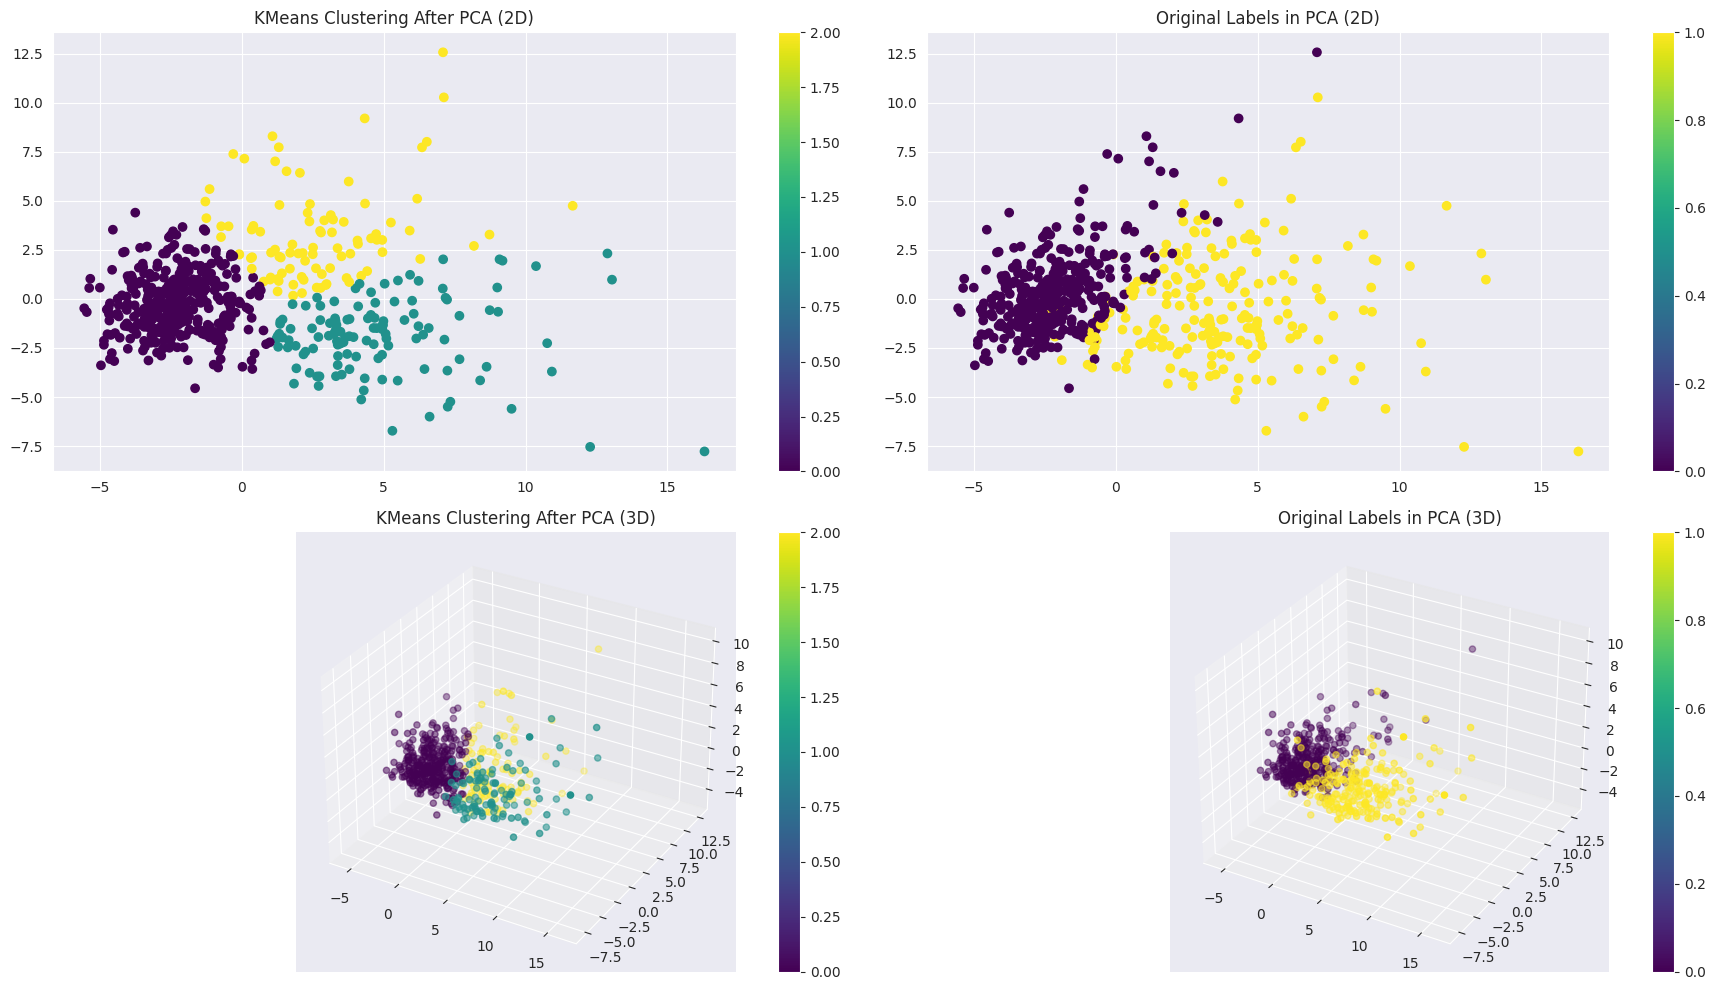

In [52]:
original_labels = data['diagnosis'].values

# 2D Visualization
fig = plt.figure(figsize=(18, 10))

# Subplot for KMeans clustering in 2D
ax1 = fig.add_subplot(2, 2, 1)
scatter1 = ax1.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels_with_pca_2d, cmap='viridis')
ax1.set_title("KMeans Clustering After PCA (2D)")
fig.colorbar(scatter1, ax=ax1)

# Subplot for Original Labels in 2D
ax2 = fig.add_subplot(2, 2, 2)
scatter2 = ax2.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=original_labels, cmap='viridis')
ax2.set_title("Original Labels in PCA (2D)")
fig.colorbar(scatter2, ax=ax2)

# 3D Visualization
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
scatter3 = ax3.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=labels_with_pca_3d, cmap='viridis')
ax3.set_title("KMeans Clustering After PCA (3D)")
fig.colorbar(scatter3, ax=ax3)

# Subplot for Original Labels in 3D
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
scatter4 = ax4.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=original_labels, cmap='viridis')
ax4.set_title("Original Labels in PCA (3D)")
fig.colorbar(scatter4, ax=ax4)

# Adjust layout for better presentation
plt.tight_layout()
plt.show()


## Comparing Results of 2nd Experiment with Original Labels using Confusion Matrix

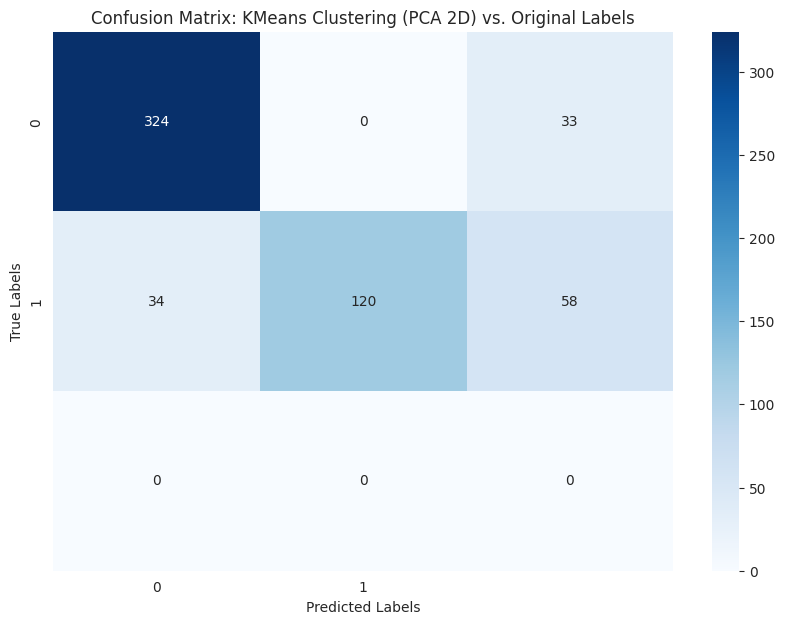

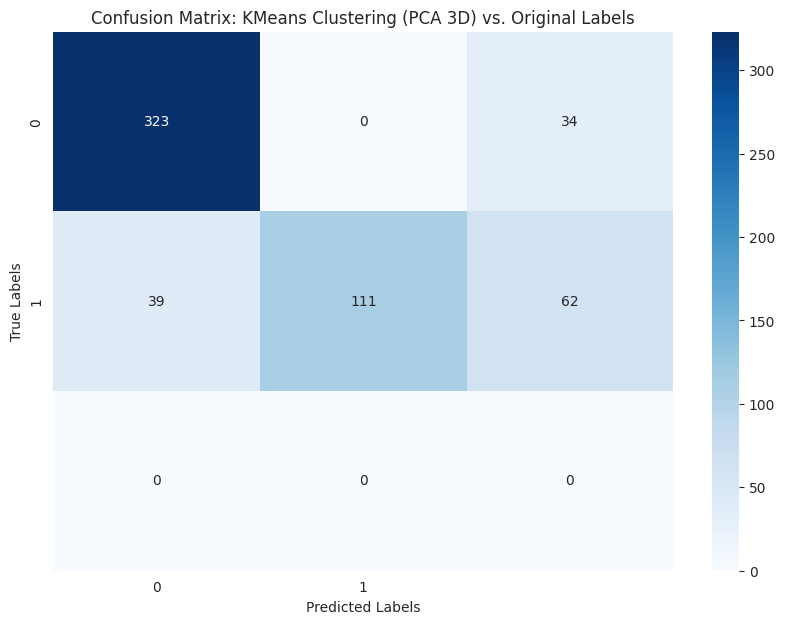

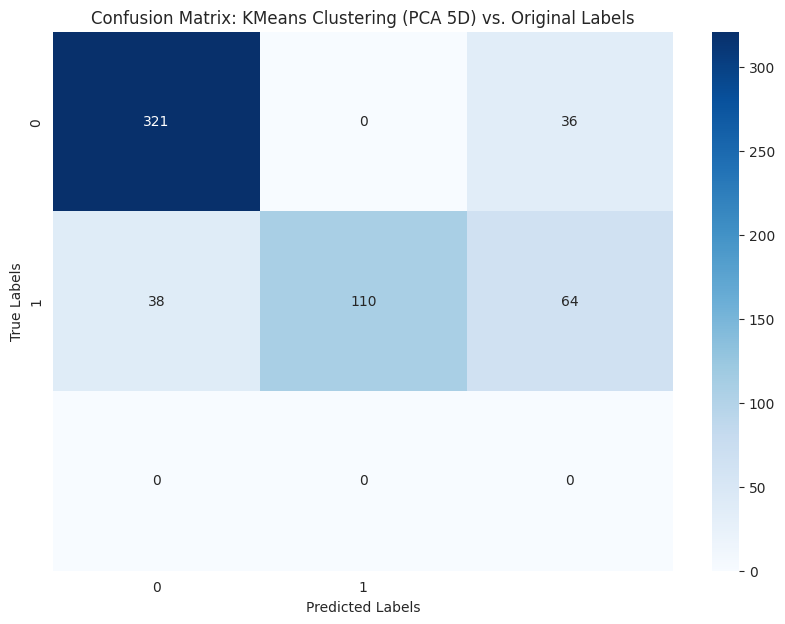

In [53]:
# Confusion Matrix for 2D PCA and KMeans clustering
conf_matrix_2d = confusion_matrix(original_labels, labels_with_pca_2d)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_2d, annot=True, fmt='d', cmap='Blues', xticklabels=set(original_labels), yticklabels=set(original_labels))
plt.title("Confusion Matrix: KMeans Clustering (PCA 2D) vs. Original Labels")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Confusion Matrix for 3D PCA and KMeans clustering
conf_matrix_3d = confusion_matrix(original_labels, labels_with_pca_3d)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_3d, annot=True, fmt='d', cmap='Blues', xticklabels=set(original_labels), yticklabels=set(original_labels))
plt.title("Confusion Matrix: KMeans Clustering (PCA 3D) vs. Original Labels")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Confusion Matrix for 5D PCA and KMeans clustering
conf_matrix_5d = confusion_matrix(original_labels, labels_with_pca_5d)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_5d, annot=True, fmt='d', cmap='Blues', xticklabels=set(original_labels), yticklabels=set(original_labels))
plt.title("Confusion Matrix: KMeans Clustering (PCA 5D) vs. Original Labels")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


## Comparing Results of 2nd Experiment with Original Labels using Cluster Purity

In [54]:
def cluster_purity(true_labels, predicted_labels):
    # Calculate purity by counting the number of correctly clustered data points
    cluster_labels = np.unique(predicted_labels)
    purity = 0.0
    for label in cluster_labels:
        cluster_data_points = true_labels[predicted_labels == label]
        most_common_class = np.bincount(cluster_data_points).argmax()
        purity += np.sum(cluster_data_points == most_common_class)
    purity /= len(true_labels)
    return purity

# Purity scores for each dimensionality reduction
purity_score_2d = cluster_purity(original_labels, labels_with_pca_2d)
purity_score_3d = cluster_purity(original_labels, labels_with_pca_3d)
purity_score_5d = cluster_purity(original_labels, labels_with_pca_5d)

print(f"Cluster Purity for PCA 2D: {purity_score_2d}")
print(f"Cluster Purity for PCA 3D: {purity_score_3d}")
print(f"Cluster Purity for PCA 5D: {purity_score_5d}")


Cluster Purity for PCA 2D: 0.8822495606326889
Cluster Purity for PCA 3D: 0.8717047451669596
Cluster Purity for PCA 5D: 0.8699472759226714


## Comparing Results of 2nd Experiment with Original Labels using Silhouette Scores

In [55]:
# Silhouette Score for KMeans clustering results (using PCA reductions)

silhouette_true_labels_2d = silhouette_score(X_pca_2d, original_labels)
silhouette_true_labels_3d = silhouette_score(X_pca_3d, original_labels)
silhouette_true_labels_5d = silhouette_score(X_pca_5d, original_labels)

# Print the silhouette scores
print(f"Silhouette Score for KMeans (2D PCA): {silhouette_with_pca_2d}")
print(f"Silhouette Score for Original Labels (2D PCA): {silhouette_true_labels_2d}")

print(f"Silhouette Score for KMeans (3D PCA): {silhouette_with_pca_3d}")
print(f"Silhouette Score for Original Labels (3D PCA): {silhouette_true_labels_3d}")

print(f"Silhouette Score for KMeans (5D PCA): {silhouette_with_pca_5d}")
print(f"Silhouette Score for Original Labels (5D PCA): {silhouette_true_labels_5d}")


Silhouette Score for KMeans (2D PCA): 0.4910071765416258
Silhouette Score for Original Labels (2D PCA): 0.4377187199877252
Silhouette Score for KMeans (3D PCA): 0.42879362596318327
Silhouette Score for Original Labels (3D PCA): 0.3948123310419593
Silhouette Score for KMeans (5D PCA): 0.36048386145415884
Silhouette Score for Original Labels (5D PCA): 0.338301385521036


## Comparing Results of 2nd Experiment with Original Labels using Homogeneity, Completeness, and V-Measure

In [56]:
homogeneity_2d = homogeneity_score(original_labels, labels_with_pca_2d)
completeness_2d = completeness_score(original_labels, labels_with_pca_2d)
v_measure_2d = v_measure_score(original_labels, labels_with_pca_2d)

homogeneity_3d = homogeneity_score(original_labels, labels_with_pca_3d)
completeness_3d = completeness_score(original_labels, labels_with_pca_3d)
v_measure_3d = v_measure_score(original_labels, labels_with_pca_3d)

homogeneity_5d = homogeneity_score(original_labels, labels_with_pca_5d)
completeness_5d = completeness_score(original_labels, labels_with_pca_5d)
v_measure_5d = v_measure_score(original_labels, labels_with_pca_5d)

# Print the scores
print(f"Homogeneity Score for KMeans (2D PCA): {homogeneity_2d}")
print(f"Completeness Score for KMeans (2D PCA): {completeness_2d}")
print(f"V-Measure Score for KMeans (2D PCA): {v_measure_2d}")

print(f"Homogeneity Score for KMeans (3D PCA): {homogeneity_3d}")
print(f"Completeness Score for KMeans (3D PCA): {completeness_3d}")
print(f"V-Measure Score for KMeans (3D PCA): {v_measure_3d}")

print(f"Homogeneity Score for KMeans (5D PCA): {homogeneity_5d}")
print(f"Completeness Score for KMeans (5D PCA): {completeness_5d}")
print(f"V-Measure Score for KMeans (5D PCA): {v_measure_5d}")


Homogeneity Score for KMeans (2D PCA): 0.5422883479757913
Completeness Score for KMeans (2D PCA): 0.392239109794337
V-Measure Score for KMeans (2D PCA): 0.4552176548550098
Homogeneity Score for KMeans (3D PCA): 0.5046485802762849
Completeness Score for KMeans (3D PCA): 0.36748486447605233
V-Measure Score for KMeans (3D PCA): 0.4252805949519018
Homogeneity Score for KMeans (5D PCA): 0.5033703794970842
Completeness Score for KMeans (5D PCA): 0.36371469466505196
V-Measure Score for KMeans (5D PCA): 0.42229582618320705


# Insights Comparing Both Experiments

**1. 5D Dimensionality:**
   For the 5D dimensionality reduction, we visualized the first two principal components while using color to represent the values of the 5th principal component. This approach allowed us to capture and display information about the 5th dimension in a 2D scatter plot, providing insight into the clustering results while addressing the challenge of visualizing more than three dimensions.
         
**2. Sum of Squared Errors (SSE):**
   - **Without PCA**: 10,044.11
   - **With PCA 2D**: 3,864.34 (Significant improvement)
   - **With PCA 3D**: 5,414.05
   - **With PCA 5D**: 7,453.68
   - **Insight**: The best clustering fit occurred with PCA 2D, showing the most significant reduction in SSE, suggesting that 2D is the optimal reduced dimensionality for this dataset.

**3. Silhouette Score:**
   - **Without PCA**: 0.31
   - **With PCA 2D**: 0.49 (Improvement)
   - **With PCA 3D**: 0.43
   - **With PCA 5D**: 0.36
   - **Insight**: The clustering quality improved with PCA 2D, showing a more defined clustering structure. As dimensionality increased beyond 2D, the Silhouette Score decreased, indicating that higher dimensions did not improve clustering quality.

**4. Overall Insights:**
   - **PCA 2D** provides the best balance of SSE reduction and clustering quality (Silhouette Score), making it the most effective dimensionality reduction technique for this dataset.
   - **Higher dimensions (3D, 5D)** resulted in higher SSE and lower Silhouette Scores, suggesting diminishing returns in clustering performance when reducing to more than 2 dimensions.


# Insights Comparing Second Experiment with Original Labels:

1. **Silhouette Score**:
   - The **Silhouette Score** for **KMeans** clustering with **2D PCA** (0.491) is higher than that of the **original labels** (0.437), indicating that the clusters formed by KMeans in 2D PCA space have a clearer separation than the true labels.
   - As the dimensionality increases, the **Silhouette Score** decreases:
     - **3D PCA**: 0.429 for KMeans, 0.395 for original labels
     - **5D PCA**: 0.360 for KMeans, 0.338 for original labels
   - **Insight**: **2D PCA** provides the best clustering structure with the highest silhouette score, suggesting clearer separation.

2. **Homogeneity, Completeness, and V-Measure**:
   - **2D PCA** shows the highest **Homogeneity Score** (0.542), meaning that the KMeans clusters are relatively pure, consisting mostly of a single class.
   - The **Completeness Score** for **2D PCA** is 0.392, suggesting that not all data points of a class belong to the same cluster.
   - **V-Measure Score** for **2D PCA** is 0.455, balancing both homogeneity and completeness.
   - As we move to **3D** and **5D PCA**, the scores decrease:
     - **3D PCA**: Homogeneity (0.505), Completeness (0.367), V-Measure (0.425)
     - **5D PCA**: Homogeneity (0.503), Completeness (0.364), V-Measure (0.422)
   - **Insight**: **2D PCA** leads to the most balanced clustering in terms of homogeneity and completeness, whereas higher dimensions (3D, 5D) show diminishing returns in clustering quality.

3. **Confusion Matrix**:
   - Even though the **target data has only two classes**, the **KMeans clustering** with **PCA** produced **three clusters**. This resulted in a **confusion matrix** that suggests three clusters instead of two.
   - **Insight**: This discrepancy arises because KMeans tries to divide the data into clusters, which are not strictly aligned with the true labels. Therefore, the number of clusters identified by KMeans (3 clusters) exceeds the number of actual classes in the data (2 classes). This highlights the challenge of clustering, especially when the data has fewer distinct classes than the algorithm generates clusters.

4. **Elbow Method**:
   - The **Elbow Method** suggested that the optimal number of clusters is **K=3**, which aligns with the result of the **KMeans clustering**. The method showed a sharp decrease in the inertia at **K=3**, reinforcing the choice of 3 clusters.
   - **Insight**: While the target data has two classes, the **Elbow method** indicated that **K=3** was the best choice for clustering, and KMeans identified three clusters accordingly.



# We will repeat what we did but instead we will use k=2 in the KMeans Clustering

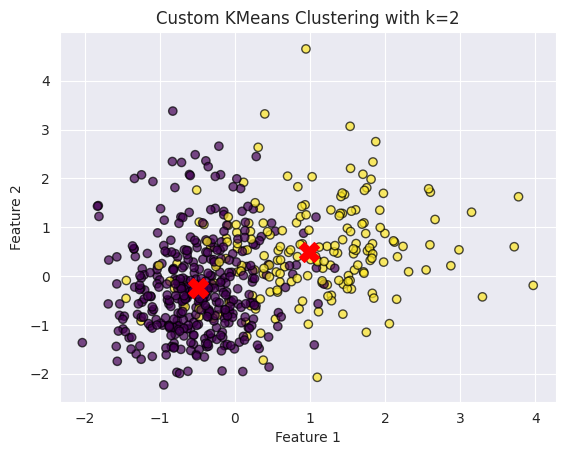

In [57]:
# Initialize custom KMeans with fixed k=2
kmeans = KMeans()

kmeans.fit(X_scaled, k=2)

# Access labels and centroids
labels = kmeans.labels
centroids = kmeans.centroids


import matplotlib.pyplot as plt
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', edgecolor='k', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200)
plt.title("Custom KMeans Clustering with k=2")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


Optimal k (Manual): 3


/tmp/ipykernel_10553/953931944.py:51: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dists = [np.abs(np.cross(p2 - p1, np.array([k, sse[k - 1]]) - p1)) / np.linalg.norm(p2 - p1) for k in range(1, self.max_k + 1)]  # Calculate the perpendicular distances from each point to the line


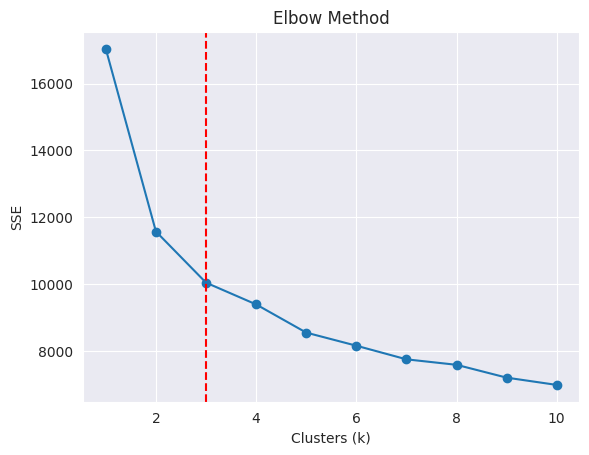

In [58]:
pca_results = perform_pca(data, target_column='diagnosis')
features_normalized = pca_results['features_normalized'].to_numpy()
eigenvectors = pca_results['eigenvectors']

kmeans_no_pca = KMeans()
kmeans_no_pca.fit(features_normalized)
labels_no_pca = kmeans.labels
silhouette_no_pca = silhouette_score(features_normalized, labels_custom)
sse_kmeans_no_pca = kmeans_no_pca.inertia_value

Optimal k (Manual): 3


/tmp/ipykernel_10553/953931944.py:51: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dists = [np.abs(np.cross(p2 - p1, np.array([k, sse[k - 1]]) - p1)) / np.linalg.norm(p2 - p1) for k in range(1, self.max_k + 1)]  # Calculate the perpendicular distances from each point to the line


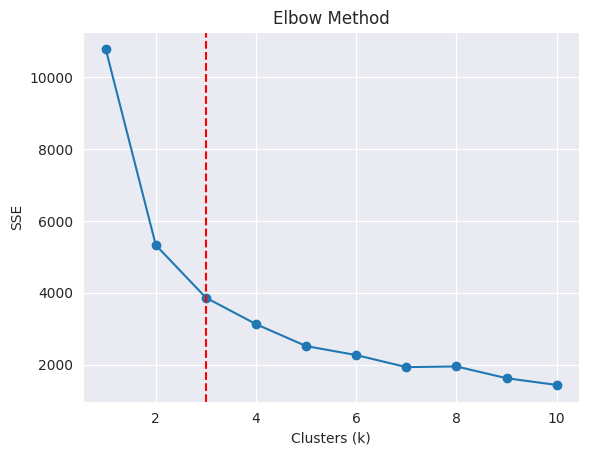

Optimal k (Manual): 3


/tmp/ipykernel_10553/953931944.py:51: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dists = [np.abs(np.cross(p2 - p1, np.array([k, sse[k - 1]]) - p1)) / np.linalg.norm(p2 - p1) for k in range(1, self.max_k + 1)]  # Calculate the perpendicular distances from each point to the line


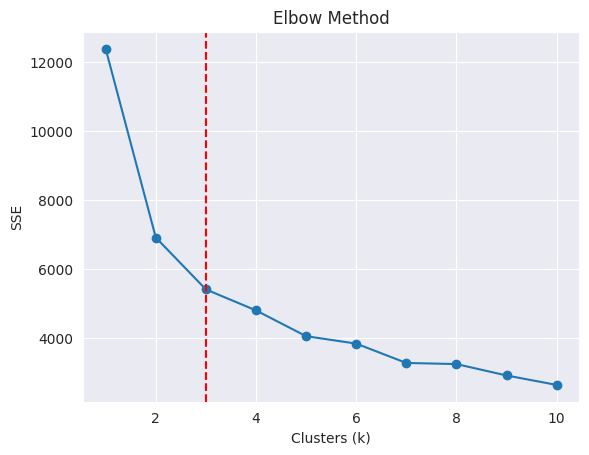

Optimal k (Manual): 3


/tmp/ipykernel_10553/953931944.py:51: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dists = [np.abs(np.cross(p2 - p1, np.array([k, sse[k - 1]]) - p1)) / np.linalg.norm(p2 - p1) for k in range(1, self.max_k + 1)]  # Calculate the perpendicular distances from each point to the line


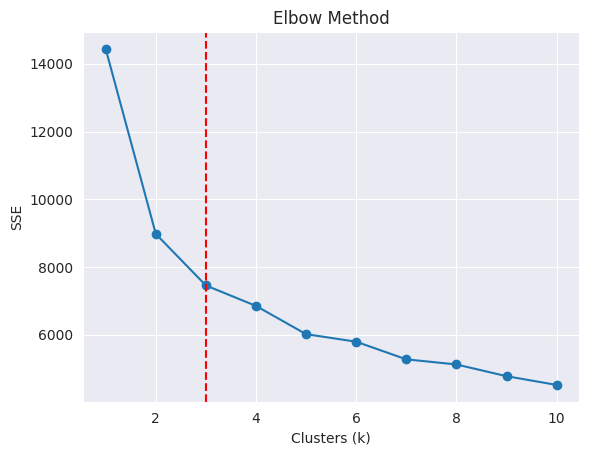

In [59]:

X_pca_2d = np.dot(features_normalized, eigenvectors[:, :2])  
X_pca_3d = np.dot(features_normalized, eigenvectors[:, :3])  
X_pca_5d = np.dot(features_normalized, eigenvectors[:, :5])  

kmeans_with_pca_2d = KMeans()
kmeans_with_pca_2d.fit(X_pca_2d)
labels_with_pca_2d = kmeans_with_pca_2d.labels
silhouette_with_pca_2d = silhouette_score(X_pca_2d, labels_with_pca_2d)
sse_kmeans_with_pca_2d = kmeans_with_pca_2d.inertia_value


kmeans_with_pca_3d = KMeans()
kmeans_with_pca_3d.fit(X_pca_3d)
labels_with_pca_3d = kmeans_with_pca_3d.labels
silhouette_with_pca_3d = silhouette_score(X_pca_3d, labels_with_pca_3d)
sse_kmeans_with_pca_3d = kmeans_with_pca_3d.inertia_value

kmeans_with_pca_5d = KMeans()
kmeans_with_pca_5d.fit(X_pca_5d)
labels_with_pca_5d = kmeans_with_pca_5d.labels
silhouette_with_pca_5d = silhouette_score(X_pca_5d, labels_with_pca_5d)
sse_kmeans_with_pca_5d = kmeans_with_pca_5d.inertia_value

In [60]:

print(f"Sum of Squared Errors for KMeans (without PCA): {sse_kmeans_no_pca}")
print(f"Sum of Squared Errors for KMeans (with PCA 2D): {sse_kmeans_with_pca_2d}")
print(f"Sum of Squared Errors for KMeans (with PCA 3D): {sse_kmeans_with_pca_3d}")
print(f"Sum of Squared Errors for KMeans (with PCA 5D): {sse_kmeans_with_pca_5d}")


print(f"Silhouette Score without PCA: {silhouette_no_pca}")
print(f"Silhouette Score with PCA (2D): {silhouette_with_pca_2d}")
print(f"Silhouette Score with PCA (3D): {silhouette_with_pca_3d}")
print(f"Silhouette Score with PCA (5D): {silhouette_with_pca_5d}")

Sum of Squared Errors for KMeans (without PCA): 10044.114518035887
Sum of Squared Errors for KMeans (with PCA 2D): 3864.3446322901145
Sum of Squared Errors for KMeans (with PCA 3D): 5414.04630161809
Sum of Squared Errors for KMeans (with PCA 5D): 7453.684447529086
Silhouette Score without PCA: 0.31438400986080983
Silhouette Score with PCA (2D): 0.4910071765416258
Silhouette Score with PCA (3D): 0.42879362596318327
Silhouette Score with PCA (5D): 0.36048386145415884


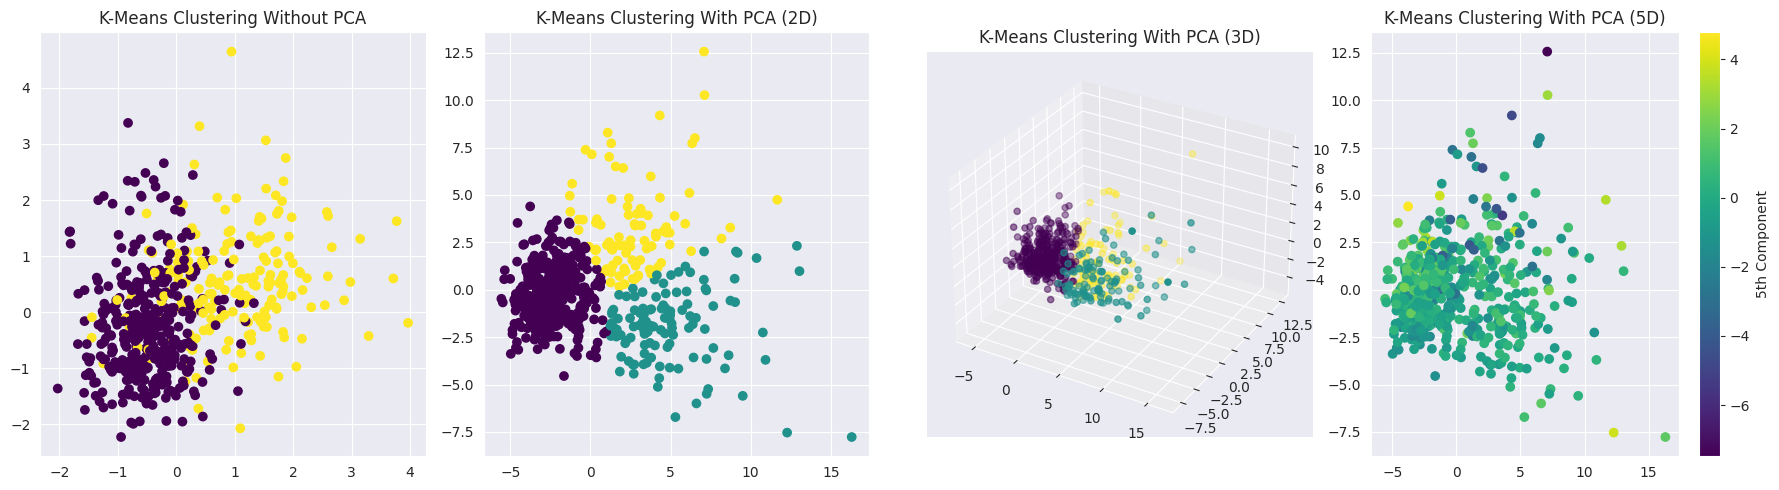

In [61]:

fig = plt.figure(figsize=(18, 5))


ax1 = fig.add_subplot(1, 4, 1)
ax1.scatter(features_normalized[:, 0], features_normalized[:, 1], c=labels_no_pca, cmap='viridis')
ax1.set_title("K-Means Clustering Without PCA")


ax2 = fig.add_subplot(1, 4, 2)
ax2.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels_with_pca_2d, cmap='viridis')
ax2.set_title("K-Means Clustering With PCA (2D)")

# 3D Visualization (with PCA - 3 components)
ax3 = fig.add_subplot(1, 4, 3, projection='3d')
ax3.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=labels_with_pca_3d, cmap='viridis')
ax3.set_title("K-Means Clustering With PCA (3D)")


# 5D Visualization (using color to represent the 4th and 5th dimensions)
ax4 = fig.add_subplot(1, 4, 4)
sc = ax4.scatter(X_pca_5d[:, 0], X_pca_5d[:, 1], c=X_pca_5d[:, 4], cmap='viridis')  # Using the 5th component for color
fig.colorbar(sc, ax=ax4, label="5th Component")
ax4.set_title("K-Means Clustering With PCA (5D)")


plt.tight_layout()
plt.show()

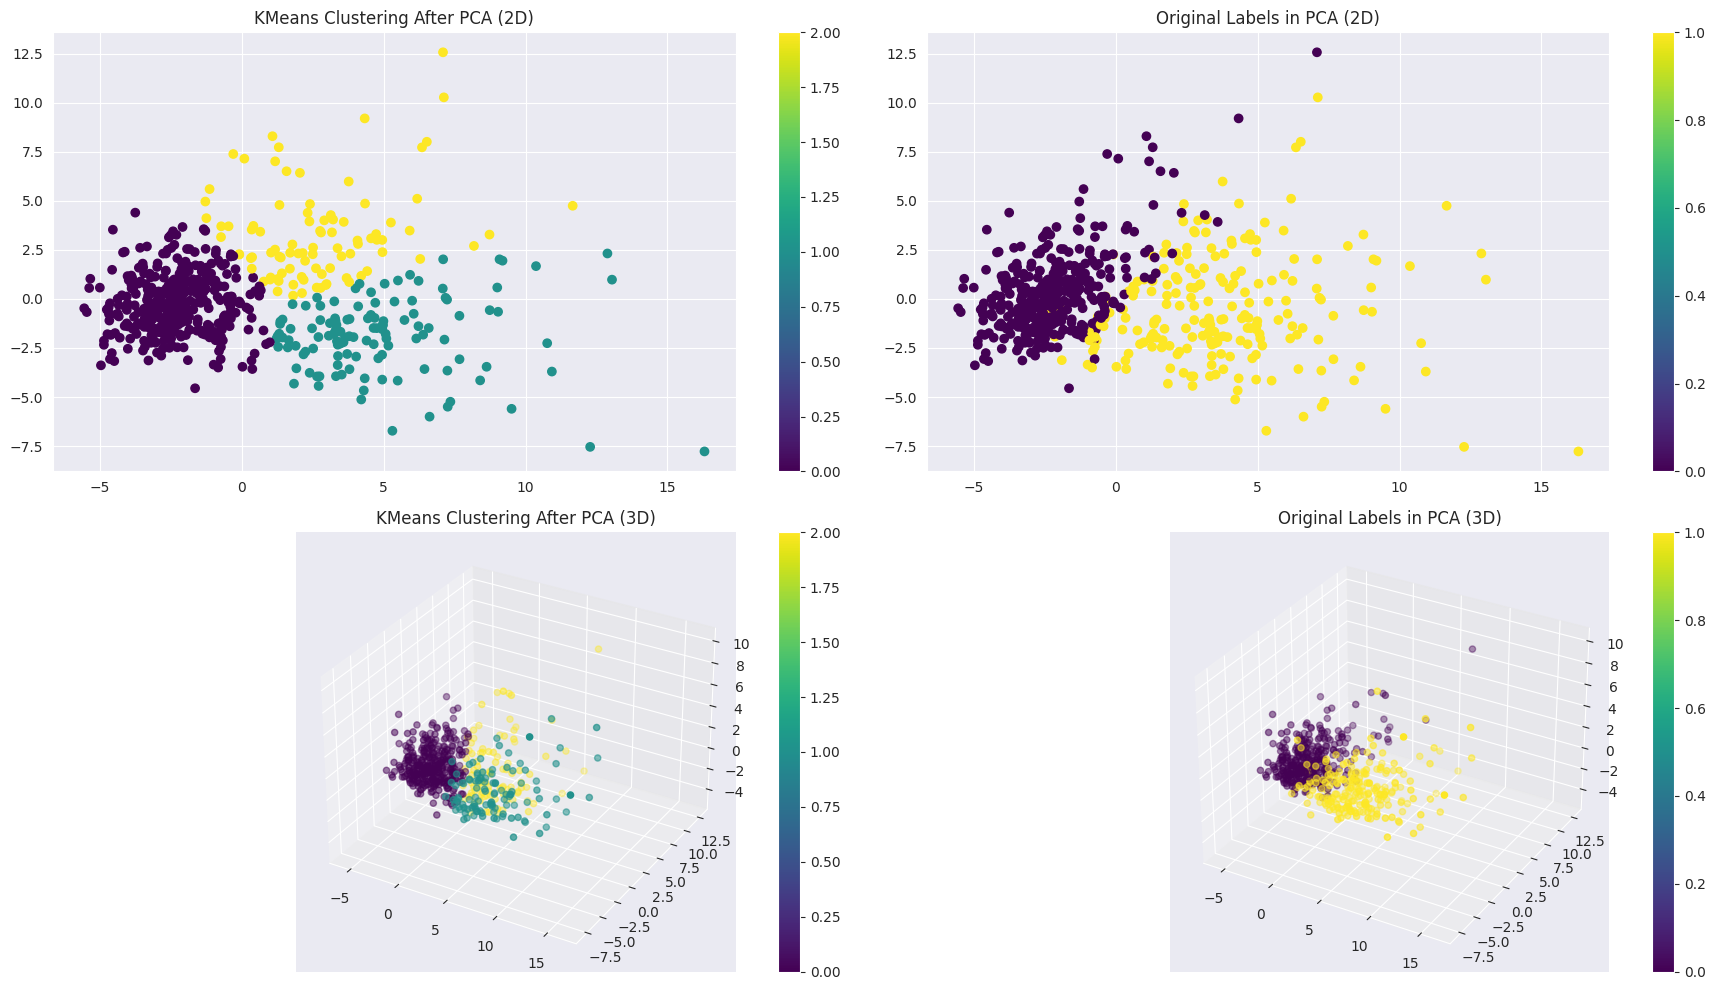

In [62]:
original_labels = data['diagnosis'].values

# 2D Visualization
fig = plt.figure(figsize=(18, 10))

# Subplot for KMeans clustering in 2D
ax1 = fig.add_subplot(2, 2, 1)
scatter1 = ax1.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels_with_pca_2d, cmap='viridis')
ax1.set_title("KMeans Clustering After PCA (2D)")
fig.colorbar(scatter1, ax=ax1)

# Subplot for Original Labels in 2D
ax2 = fig.add_subplot(2, 2, 2)
scatter2 = ax2.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=original_labels, cmap='viridis')
ax2.set_title("Original Labels in PCA (2D)")
fig.colorbar(scatter2, ax=ax2)

# 3D Visualization
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
scatter3 = ax3.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=labels_with_pca_3d, cmap='viridis')
ax3.set_title("KMeans Clustering After PCA (3D)")
fig.colorbar(scatter3, ax=ax3)

# Subplot for Original Labels in 3D
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
scatter4 = ax4.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=original_labels, cmap='viridis')
ax4.set_title("Original Labels in PCA (3D)")
fig.colorbar(scatter4, ax=ax4)

# Adjust layout for better presentation
plt.tight_layout()
plt.show()


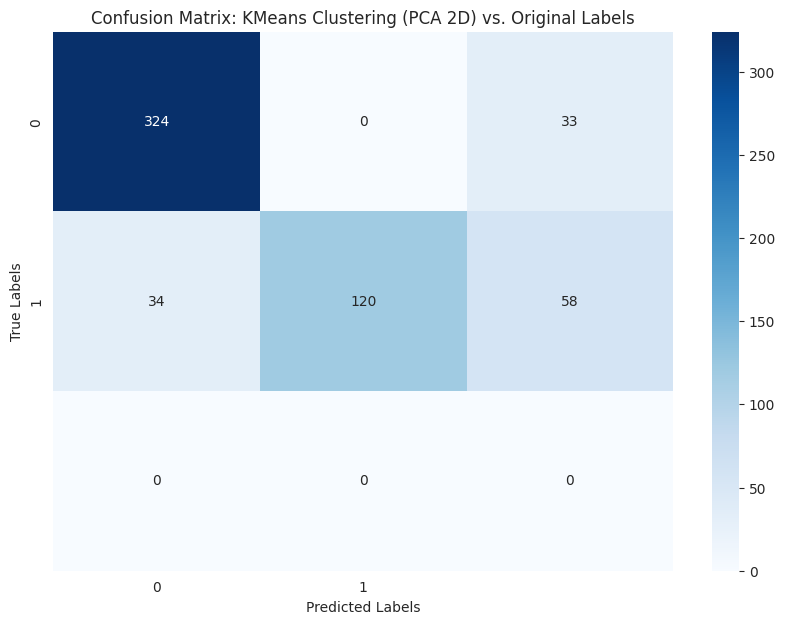

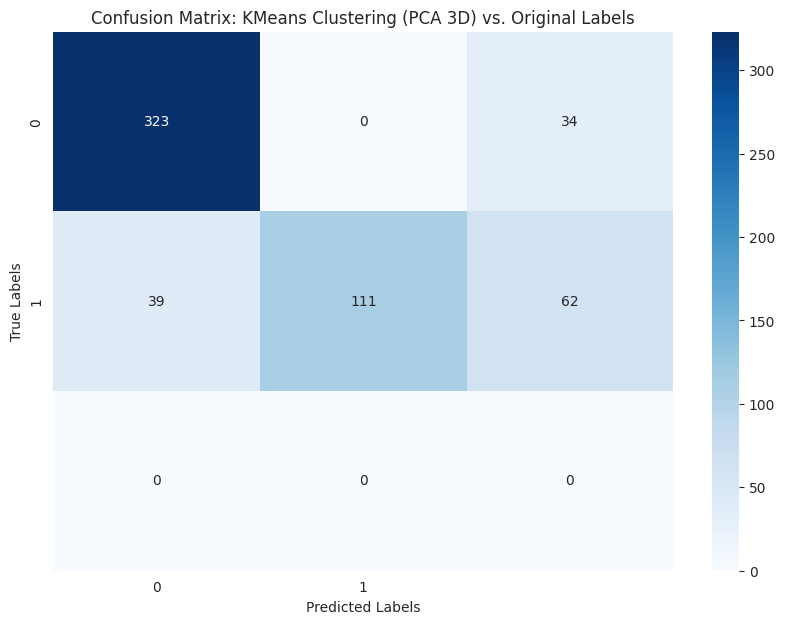

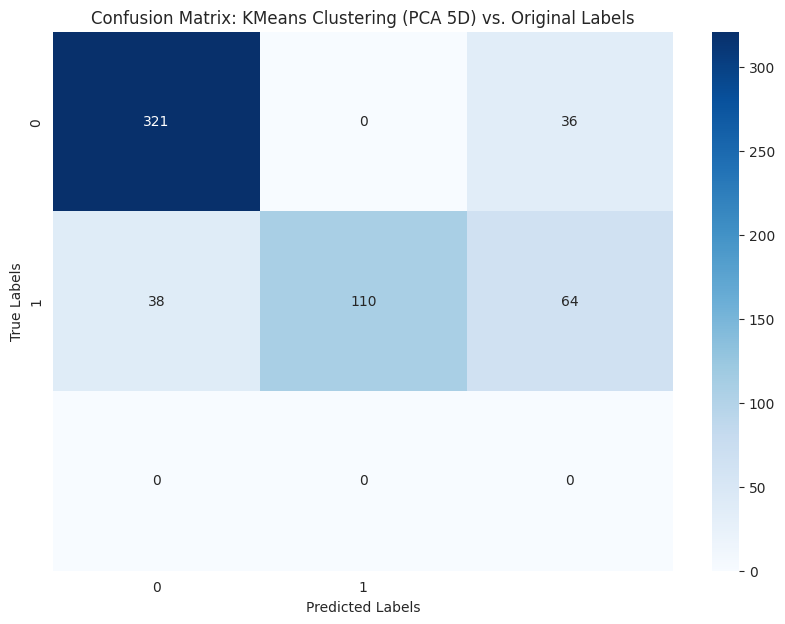

In [63]:
# Confusion Matrix for 2D PCA and KMeans clustering
conf_matrix_2d = confusion_matrix(original_labels, labels_with_pca_2d)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_2d, annot=True, fmt='d', cmap='Blues', xticklabels=set(original_labels), yticklabels=set(original_labels))
plt.title("Confusion Matrix: KMeans Clustering (PCA 2D) vs. Original Labels")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Confusion Matrix for 3D PCA and KMeans clustering
conf_matrix_3d = confusion_matrix(original_labels, labels_with_pca_3d)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_3d, annot=True, fmt='d', cmap='Blues', xticklabels=set(original_labels), yticklabels=set(original_labels))
plt.title("Confusion Matrix: KMeans Clustering (PCA 3D) vs. Original Labels")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Confusion Matrix for 5D PCA and KMeans clustering
conf_matrix_5d = confusion_matrix(original_labels, labels_with_pca_5d)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_5d, annot=True, fmt='d', cmap='Blues', xticklabels=set(original_labels), yticklabels=set(original_labels))
plt.title("Confusion Matrix: KMeans Clustering (PCA 5D) vs. Original Labels")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [64]:
def cluster_purity(true_labels, predicted_labels):
    # Calculate purity by counting the number of correctly clustered data points
    cluster_labels = np.unique(predicted_labels)
    purity = 0.0
    for label in cluster_labels:
        cluster_data_points = true_labels[predicted_labels == label]
        most_common_class = np.bincount(cluster_data_points).argmax()
        purity += np.sum(cluster_data_points == most_common_class)
    purity /= len(true_labels)
    return purity

# Purity scores for each dimensionality reduction
purity_score_2d = cluster_purity(original_labels, labels_with_pca_2d)
purity_score_3d = cluster_purity(original_labels, labels_with_pca_3d)
purity_score_5d = cluster_purity(original_labels, labels_with_pca_5d)

print(f"Cluster Purity for PCA 2D: {purity_score_2d}")
print(f"Cluster Purity for PCA 3D: {purity_score_3d}")
print(f"Cluster Purity for PCA 5D: {purity_score_5d}")


Cluster Purity for PCA 2D: 0.8822495606326889
Cluster Purity for PCA 3D: 0.8717047451669596
Cluster Purity for PCA 5D: 0.8699472759226714


In [65]:
# Silhouette Score for KMeans clustering results (using PCA reductions)

silhouette_true_labels_2d = silhouette_score(X_pca_2d, original_labels)
silhouette_true_labels_3d = silhouette_score(X_pca_3d, original_labels)
silhouette_true_labels_5d = silhouette_score(X_pca_5d, original_labels)

# Print the silhouette scores
print(f"Silhouette Score for KMeans (2D PCA): {silhouette_with_pca_2d}")
print(f"Silhouette Score for Original Labels (2D PCA): {silhouette_true_labels_2d}")

print(f"Silhouette Score for KMeans (3D PCA): {silhouette_with_pca_3d}")
print(f"Silhouette Score for Original Labels (3D PCA): {silhouette_true_labels_3d}")

print(f"Silhouette Score for KMeans (5D PCA): {silhouette_with_pca_5d}")
print(f"Silhouette Score for Original Labels (5D PCA): {silhouette_true_labels_5d}")


Silhouette Score for KMeans (2D PCA): 0.4910071765416258
Silhouette Score for Original Labels (2D PCA): 0.4377187199877252
Silhouette Score for KMeans (3D PCA): 0.42879362596318327
Silhouette Score for Original Labels (3D PCA): 0.3948123310419593
Silhouette Score for KMeans (5D PCA): 0.36048386145415884
Silhouette Score for Original Labels (5D PCA): 0.338301385521036


In [66]:
homogeneity_2d = homogeneity_score(original_labels, labels_with_pca_2d)
completeness_2d = completeness_score(original_labels, labels_with_pca_2d)
v_measure_2d = v_measure_score(original_labels, labels_with_pca_2d)

homogeneity_3d = homogeneity_score(original_labels, labels_with_pca_3d)
completeness_3d = completeness_score(original_labels, labels_with_pca_3d)
v_measure_3d = v_measure_score(original_labels, labels_with_pca_3d)

homogeneity_5d = homogeneity_score(original_labels, labels_with_pca_5d)
completeness_5d = completeness_score(original_labels, labels_with_pca_5d)
v_measure_5d = v_measure_score(original_labels, labels_with_pca_5d)

# Print the scores
print(f"Homogeneity Score for KMeans (2D PCA): {homogeneity_2d}")
print(f"Completeness Score for KMeans (2D PCA): {completeness_2d}")
print(f"V-Measure Score for KMeans (2D PCA): {v_measure_2d}")

print(f"Homogeneity Score for KMeans (3D PCA): {homogeneity_3d}")
print(f"Completeness Score for KMeans (3D PCA): {completeness_3d}")
print(f"V-Measure Score for KMeans (3D PCA): {v_measure_3d}")

print(f"Homogeneity Score for KMeans (5D PCA): {homogeneity_5d}")
print(f"Completeness Score for KMeans (5D PCA): {completeness_5d}")
print(f"V-Measure Score for KMeans (5D PCA): {v_measure_5d}")


Homogeneity Score for KMeans (2D PCA): 0.5422883479757913
Completeness Score for KMeans (2D PCA): 0.392239109794337
V-Measure Score for KMeans (2D PCA): 0.4552176548550098
Homogeneity Score for KMeans (3D PCA): 0.5046485802762849
Completeness Score for KMeans (3D PCA): 0.36748486447605233
V-Measure Score for KMeans (3D PCA): 0.4252805949519018
Homogeneity Score for KMeans (5D PCA): 0.5033703794970842
Completeness Score for KMeans (5D PCA): 0.36371469466505196
V-Measure Score for KMeans (5D PCA): 0.42229582618320705


### Overall Conclusion:
* Despite the target having **two classes**, the **KMeans** clustering with **PCA** generated **three clusters**, as reflected in the **confusion matrix**. This number of clusters (**K=3**) was derived from the **Elbow method**, which suggested that three clusters would provide the best fit for the data. **2D PCA** provided the most effective clustering solution with the best balance of **Silhouette Scores**, **Homogeneity**, **Completeness**, and **V-Measure**, but KMeans may sometimes generate more clusters than there are actual classes in the target, depending on the algorithm's behavior.
* When comparing **\( k=2 \)** and **\( k=3 \)**, the choice of **\( k \)** significantly **impacts the clustering results**. 

* With **\( k=2 \)**, the KMeans clustering aligns more naturally with **binary classification tasks**, such as distinguishing between two target classes (e.g., benign and malignant). The clusters are more interpretable and simpler to analyze, making this choice ideal for datasets with two primary groups. However, it may oversimplify the data, failing to capture finer sub-group distinctions.

* With **\( k=3 \)**, the KMeans algorithm introduces an **additional cluster**, potentially identifying a meaningful subgroup or over-segmenting one of the primary groups. This result was initially derived from the Elbow method, which suggested that three clusters provided the best fit for the data. While **\( k=3 \)** might provide deeper insights, it can introduce unnecessary complexity and ambiguity if the third cluster does not represent a natural division in the data.

* Overall, **\( k=2 \)** is better suited for cases where the data has two distinct groups, while **\( k=3 \)** may be preferable for exploratory analysis or datasets with underlying complexities that require finer granularity.